In [1]:
import sys
sys.path.append('/Users/jinchen/Desktop/DSE/IntroML/Project/project-product-price-prediction')

In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
matplotlib.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['figure.constrained_layout.use'] = True


# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression # F-value between label/feature for regression tasks.


# model
import lightgbm as lgbm
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor


from final.random_sampling.even_sample_brand import stratified_sampling_by_brand
from final.random_sampling.even_sample_category import stratified_sampling_by_category
from final.random_sampling.even_sample_by_price_range import stratified_sampling_by_price
from final.feature_extraction.text_vectorization import encode_categories,encode_string_column


from final.model_evaluation.error_function import mape
from final.model_evaluation.visualizations import plot_prediction_price
from final.model_evaluation.regression_cvs import find_train_best_model
from final.model_evaluation.keras_model import neural_network
from final.model_evaluation.regression_evaluation import reg_evaluation, get_ori_price
from final.model_evaluation.visualizations import plot_loss

Using TensorFlow backend.


# Get sample df

In [6]:
df = pd.read_csv("../../data/clean_data_with_text_features.csv")
df = stratified_sampling_by_brand(df, file_dir="data",number_samples = 50000,
                                               replace = False, save_sample_df = False)

ZeroDivisionError: division by zero

In [8]:
df.to_csv("sampling_50000_brand_name_data.csv")

In [7]:
df.shape

(50000, 46)

In [5]:
df.head(5)

,,train_id,item_condition_id,brand_name,price,shipping,c1,c2,c3,clean_name,clean_description,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
brand_name,,,,,,,,,,,,,,,,,,,,,,
amazonbasics,1154144,1155262,3,amazonbasics,106.0,0,electronics,tv audio surveillance,gadget,amazon echo with alexa,amazon echo in excellent condition functionall...,...,0.297297,0.352941,1.000000,0.785714,0.111111,0.034483,0.052632,0.131148,0.024904,0.011834
missing,277913,278153,1,missing,12.0,1,beauty,makeup,eye,anastasia beverly hills brow definers,items are new in box never used colors are ebo...,...,0.162162,0.205882,1.000000,0.428571,0.000000,0.034483,0.000000,0.139344,0.024904,0.014201
casio,515422,515904,3,casio,36.0,0,men,men s accessories,watch,men s g shock,black with red detail used owned for less than...,...,0.108108,0.147059,1.000000,0.285714,0.000000,0.068966,0.000000,0.032787,0.005747,0.002367
rave,1267028,1268245,1,rave,20.0,0,woman,tops blouses,t shirts,little black diamond rave top,brand new never worn size large but runs small...,...,0.081081,0.117647,1.000000,0.214286,0.000000,0.000000,0.000000,0.008197,0.000000,0.000000
hot topic,462438,462849,3,hot topic,12.0,0,woman,sweater,crewneck,skull hot topic sweater,very nice sweater cool detail on the side grea...,...,0.216216,0.235294,0.888889,0.250000,0.000000,0.000000,0.000000,0.024590,0.001916,0.001183


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 50000 entries, ('amazonbasics', 1154144) to ('hot wheels', 179690)
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   train_id                          50000 non-null  int64  
 1   item_condition_id                 50000 non-null  int64  
 2   brand_name                        50000 non-null  object 
 3   price                             50000 non-null  float64
 4   shipping                          50000 non-null  int64  
 5   c1                                50000 non-null  object 
 6   c2                                50000 non-null  object 
 7   c3                                50000 non-null  object 
 8   clean_name                        50000 non-null  object 
 9   clean_description                 50000 non-null  object 
 10  clean_nameWordCount               50000 non-null  float64
 11  clean_nameLength          

# Train Test Split

In [7]:
Y = np.log1p(df['price'])
df.drop(['price'], axis=1, inplace=True)
df.head(2)

,,train_id,item_condition_id,brand_name,shipping,c1,c2,c3,clean_name,clean_description,clean_nameWordCount,...,brand_nameLength,brand_nameLowerCount,brand_nameLowerRatio,brand_nameAvgWordLen,nameStopWordCount,namePunctuationCount,nameSpecialCount,item_descriptionStopWordCount,item_descriptionPunctuationCount,item_descriptionSpecialCount
brand_name,,,,,,,,,,,,,,,,,,,,,,
amazonbasics,1154144,1155262,3,amazonbasics,0,electronics,tv audio surveillance,gadget,amazon echo with alexa,amazon echo in excellent condition functionall...,0.1875,...,0.297297,0.352941,1.0,0.785714,0.111111,0.034483,0.052632,0.131148,0.024904,0.011834
missing,277913,278153,1,missing,1,beauty,makeup,eye,anastasia beverly hills brow definers,items are new in box never used colors are ebo...,0.2500,...,0.162162,0.205882,1.0,0.428571,0.000000,0.034483,0.000000,0.139344,0.024904,0.014201


In [8]:
train_df, test_df , y_train, y_test = train_test_split(df, Y, test_size=0.2, random_state=12342)
print('Train size: %s, Test size: %s'%(train_df.shape, test_df.shape))

Train size: (40000, 45), Test size: (10000, 45)


# Vectorization

In [9]:
train_cat_features, test_cat_features, train_cat_features_name = encode_categories(train_df, test_df,
                                                                columns = ['c1','c2','c3','brand_name'], 
                                                                min_df = 10, print_progress=True)

Size of vectorization features of c1 is 12
Size of vectorization features of c2 is 106
Size of vectorization features of c3 is 379
Size of vectorization features of brand_name is 726
Shape of train vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (40000, 1223)
Shape of test vectorization features of ['c1', 'c2', 'c3', 'brand_name'] is (10000, 1223)


In [10]:
train_str_features, test_str_features, train_str_features_name = encode_string_column(train_df, test_df,
                                                                   columns=['clean_name', 'clean_description'],
                                                                   min_df=10, max_features=15000, 
                                                                   print_progress=True)

Size of vectorization features of clean_name is 3629
Size of vectorization features of clean_description is 15000
Shape of train vectorization features of ['clean_name', 'clean_description'] is (40000, 18629)
Shape of test vectorization features of ['clean_name', 'clean_description'] is (10000, 18629)


# Combine all features

In [11]:
other_columns = list(train_df.select_dtypes([np.number]).columns)
other_columns.remove('train_id')

In [12]:
train_other_features = train_df[other_columns].values
test_other_features = test_df[other_columns].values
print('Train other features size: %s, Test other features size: %s'%(train_other_features.shape, 
                                                                     test_other_features.shape))

Train other features size: (40000, 38), Test other features size: (10000, 38)


In [13]:
all_train = np.hstack((train_cat_features, train_str_features, train_other_features))
all_test = np.hstack((test_cat_features, test_str_features, test_other_features))
print('Train features size: %s, Test features size: %s'%(all_train.shape, 
                                                         all_test.shape))

Train features size: (40000, 19890), Test features size: (10000, 19890)


# Feature Selection

# Select K Best

In [16]:
skb = SelectKBest(f_regression, k=500)
x_skb_select_train = skb.fit_transform(all_train, y_train)
x_skb_select_test = skb.transform(all_test)

In [17]:
x_skb_select_train.shape

(40000, 500)

In [18]:
x_skb_select_test.shape

(10000, 500)

# Best Hyparameter Test

### Ridge Model - Select K Best

In [19]:
ridge_model = Ridge(max_iter=100, tol=0.05, alpha=6.0)
ridge_model.fit(x_skb_select_train, y_train)
ridge_train_pred = ridge_model.predict(x_skb_select_train)
ridge_test_pred = ridge_model.predict(x_skb_select_test)

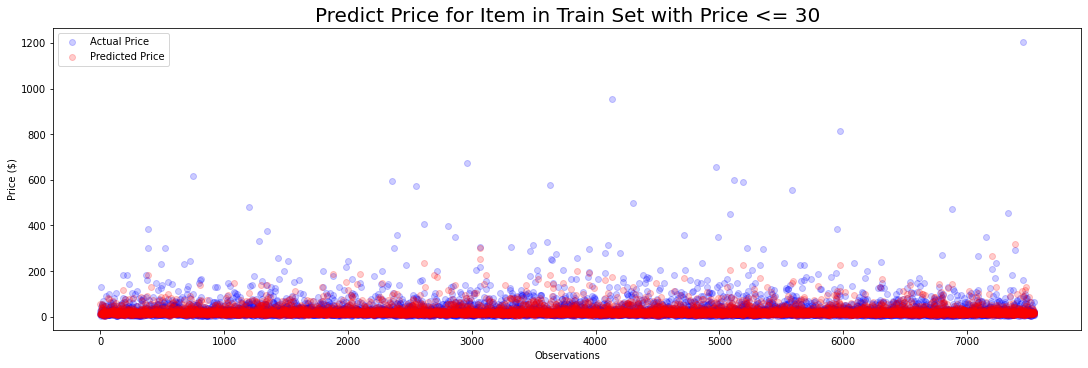

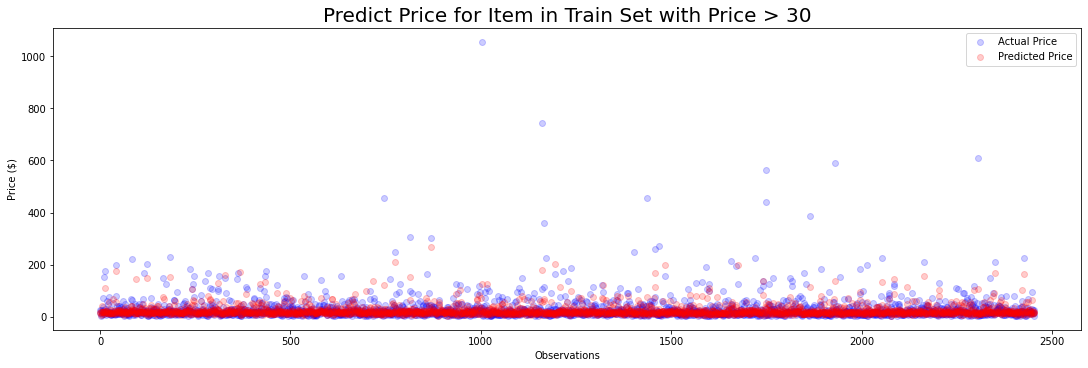

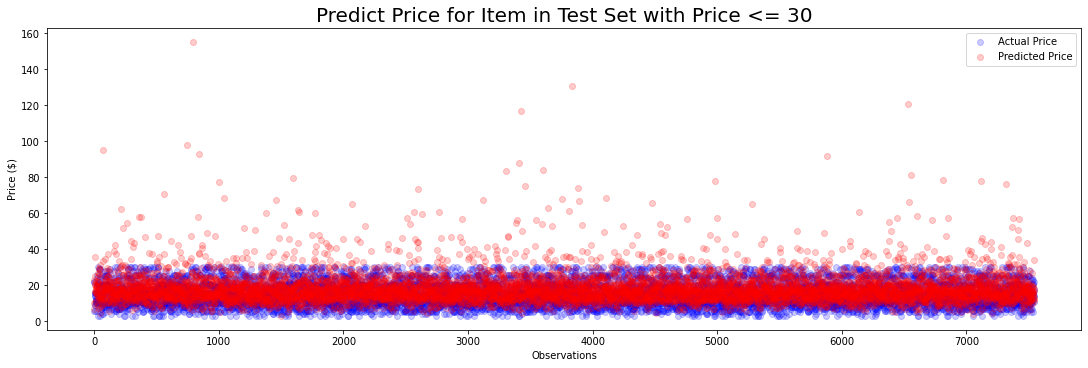

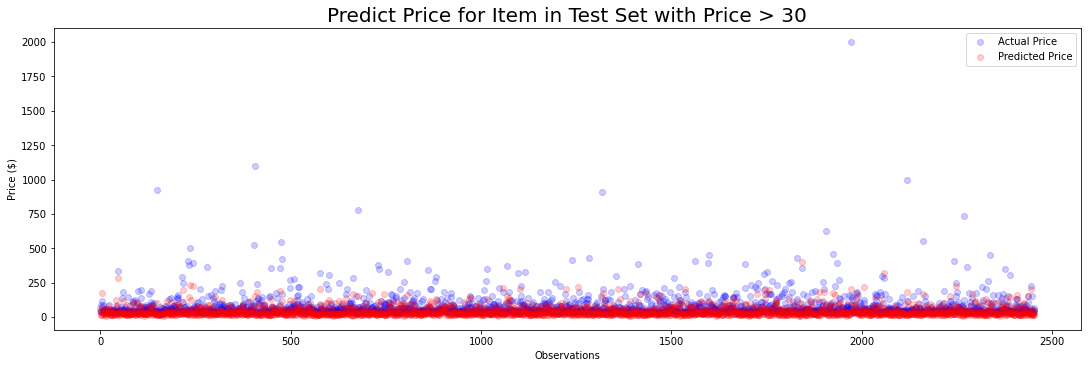

Max Percentage Difference: 1070.52 ---- Original Price 4.00, Predict Price 46.82 
Min Percentage Difference: 0.00 ---- Original Price 12.00, Predict Price 12.00 
Max Percentage Difference: 1070.52 ---- Original Price 4.00, Predict Price 46.82 
Min Percentage Difference: 0.00 ---- Original Price 12.00, Predict Price 12.00 
Max Percentage Difference: 395.39 ---- Original Price 49.00, Predict Price 242.74 
Min Percentage Difference: 0.04 ---- Original Price 32.00, Predict Price 32.01 
Max Percentage Difference: 2276.11 ---- Original Price 4.00, Predict Price 95.04 
Min Percentage Difference: 0.00 ---- Original Price 22.00, Predict Price 22.00 
Max Percentage Difference: 2276.11 ---- Original Price 4.00, Predict Price 95.04 
Min Percentage Difference: 0.00 ---- Original Price 22.00, Predict Price 22.00 
Max Percentage Difference: 370.74 ---- Original Price 40.00, Predict Price 188.30 
Min Percentage Difference: 0.03 ---- Original Price 81.00, Predict Price 81.02 


In [22]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, ridge_train_pred, 
                                                                                   y_test,ridge_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train, ridge_train_pred, y_test, ridge_test_pred,
               price_split=30,print_result = False)

In [23]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,1070.520134,0.000465,0.564906,0.457023,50.704581,13.936410
Train with Price <= 30,1070.520134,0.000465,0.463730,-0.074315,52.425747,6.230508
Train with Price > 30,395.389547,0.041065,0.801339,-0.990611,45.362379,37.854198
All Test,2276.113260,0.001206,0.571909,0.443191,52.067207,14.188017
Test with Price <= 30,2276.113260,0.001206,0.471259,-0.098161,53.922204,6.314141
Test with Price > 30,370.739813,0.025619,0.806077,-1.000708,46.366206,38.386953


### Ridge Model - All features

In [25]:
ridge_model = Ridge(max_iter=100, tol=0.05, alpha=6.0)
ridge_model.fit(all_train, y_train)
ridge_train_pred = ridge_model.predict(all_train)
ridge_test_pred = ridge_model.predict(all_test)

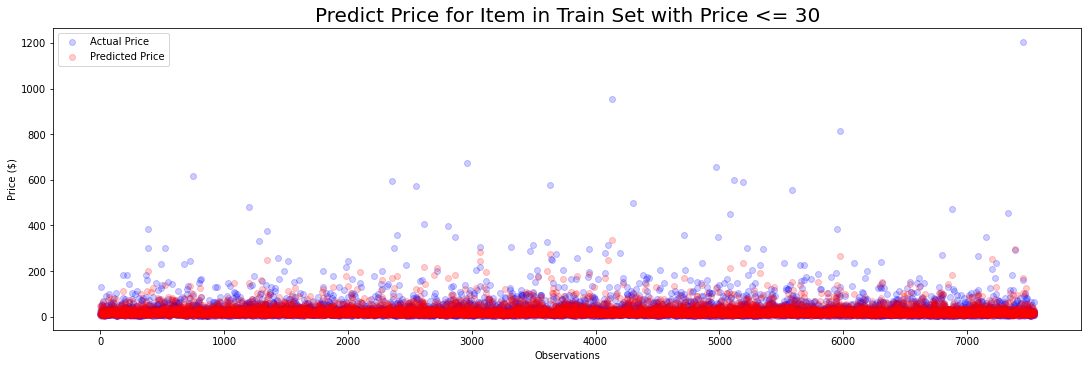

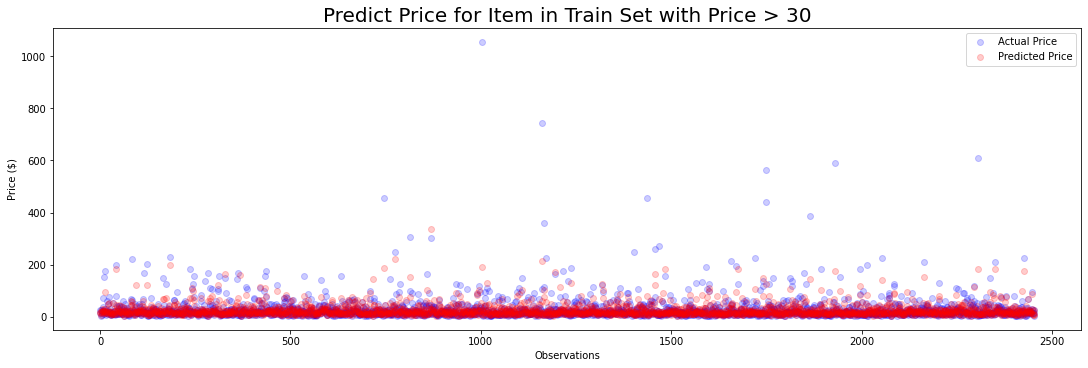

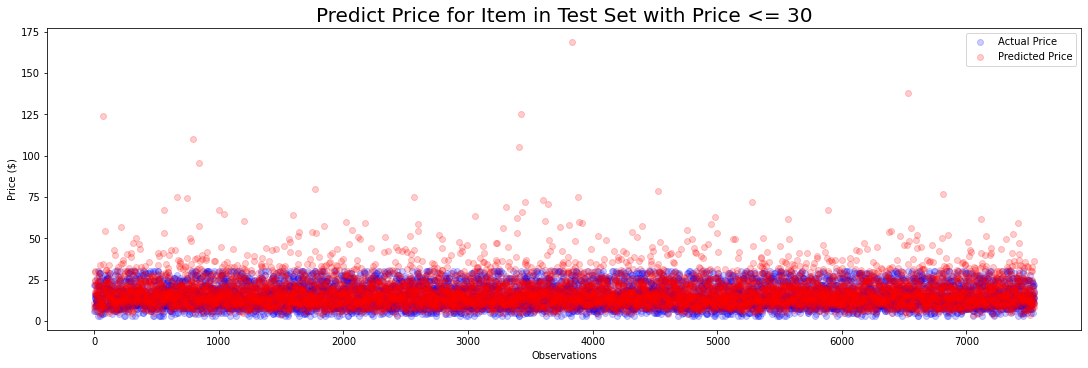

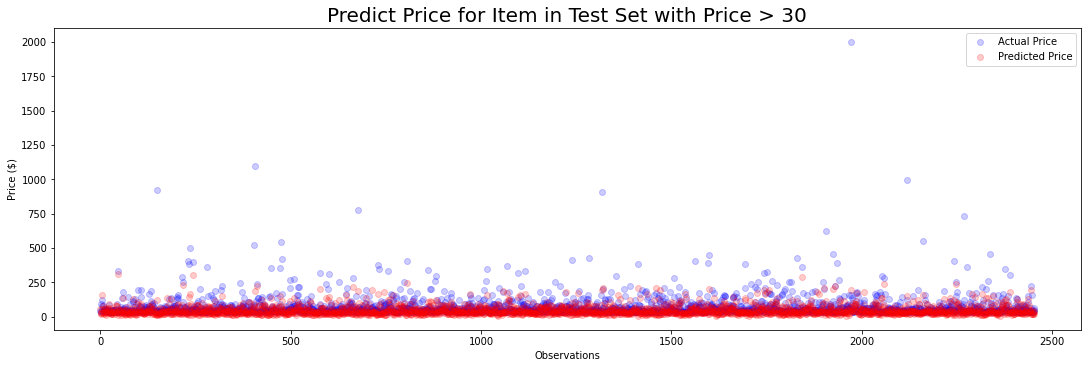

Max Percentage Difference: 921.50 ---- Original Price 4.00, Predict Price 40.86 
Min Percentage Difference: 0.00 ---- Original Price 50.00, Predict Price 50.00 
Max Percentage Difference: 921.50 ---- Original Price 4.00, Predict Price 40.86 
Min Percentage Difference: 0.00 ---- Original Price 21.00, Predict Price 21.00 
Max Percentage Difference: 366.61 ---- Original Price 33.00, Predict Price 153.98 
Min Percentage Difference: 0.00 ---- Original Price 50.00, Predict Price 50.00 
Max Percentage Difference: 3007.91 ---- Original Price 4.00, Predict Price 124.32 
Min Percentage Difference: 0.01 ---- Original Price 34.00, Predict Price 34.00 
Max Percentage Difference: 3007.91 ---- Original Price 4.00, Predict Price 124.32 
Min Percentage Difference: 0.02 ---- Original Price 19.00, Predict Price 19.00 
Max Percentage Difference: 278.06 ---- Original Price 40.00, Predict Price 151.22 
Min Percentage Difference: 0.01 ---- Original Price 34.00, Predict Price 34.00 


In [33]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, ridge_train_pred, 
                                                                                   y_test,ridge_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train, ridge_train_pred, y_test, ridge_test_pred,
               price_split=30,print_result = False)

In [34]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,921.504377,0.000499,0.421632,0.697521,36.373187,10.970849
Train with Price <= 30,921.504377,0.002145,0.365200,0.333711,37.105073,4.802385
Train with Price > 30,366.605885,0.000499,0.561774,0.021688,34.101541,30.116695
All Test,3007.910516,0.011675,0.478878,0.609606,42.486964,12.193621
Test with Price <= 30,3007.910516,0.020066,0.416764,0.141130,43.906968,5.559705
Test with Price > 30,278.056505,0.011675,0.632691,-0.232578,38.122839,32.581766


## RandomForestRegressor

### Train with select k best features

In [35]:
rf_model = RandomForestRegressor(n_estimators=500, max_features=50)
rf_model.fit(x_skb_select_train, y_train)
rf_train_pred = rf_model.predict(x_skb_select_train)
rf_test_pred = rf_model.predict(x_skb_select_test)

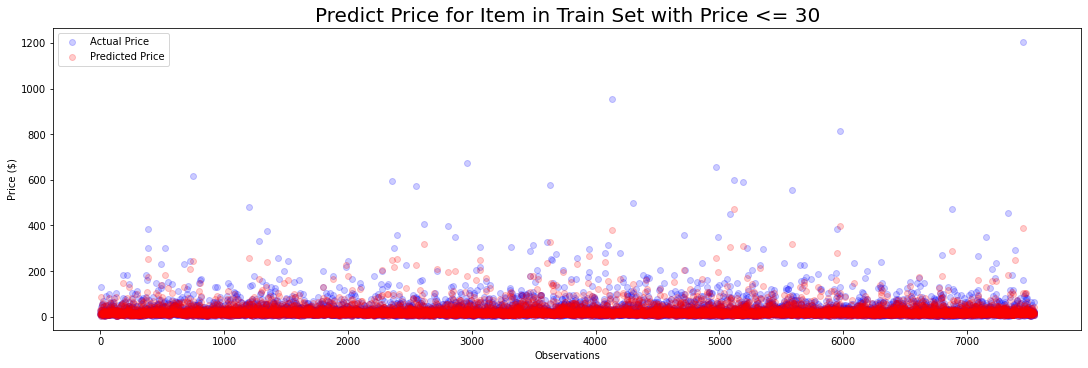

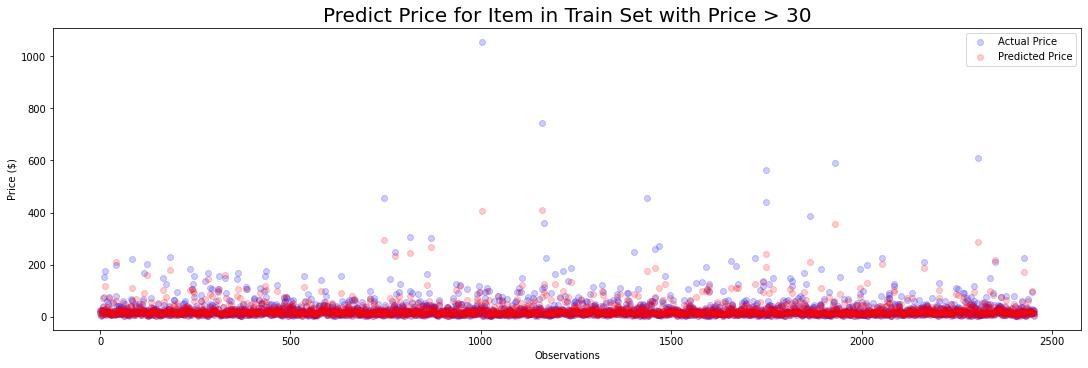

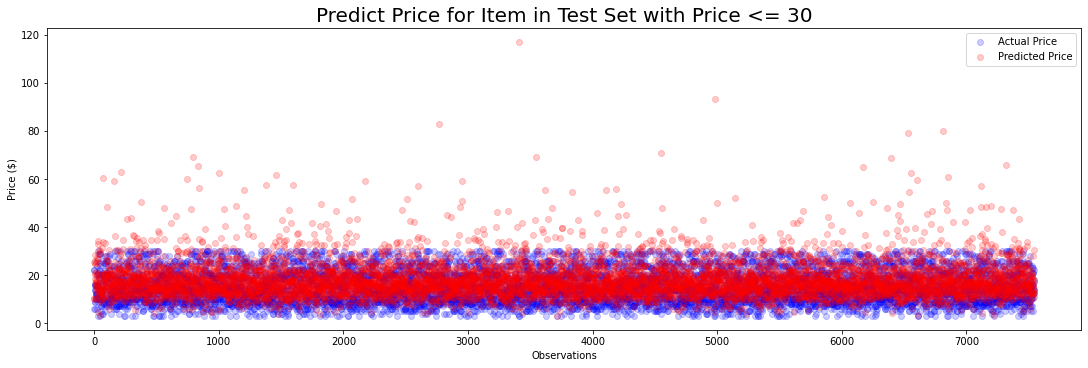

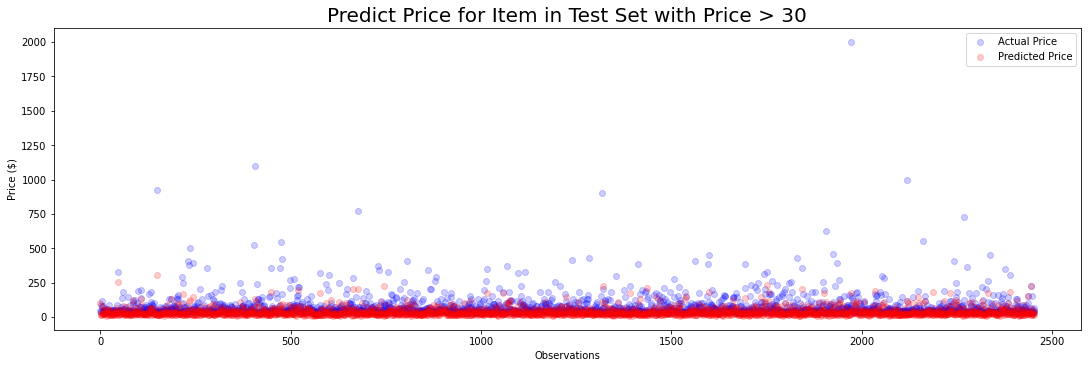

Max Percentage Difference: 175.12 ---- Original Price 4.00, Predict Price 11.00 
Min Percentage Difference: 0.00 ---- Original Price 15.00, Predict Price 15.00 
Max Percentage Difference: 175.12 ---- Original Price 4.00, Predict Price 11.00 
Min Percentage Difference: 0.00 ---- Original Price 15.00, Predict Price 15.00 
Max Percentage Difference: 73.85 ---- Original Price 675.00, Predict Price 176.49 
Min Percentage Difference: 0.00 ---- Original Price 35.00, Predict Price 35.00 
Max Percentage Difference: 2230.57 ---- Original Price 4.00, Predict Price 93.22 
Min Percentage Difference: 0.01 ---- Original Price 13.00, Predict Price 13.00 
Max Percentage Difference: 2230.57 ---- Original Price 4.00, Predict Price 93.22 
Min Percentage Difference: 0.01 ---- Original Price 13.00, Predict Price 13.00 
Max Percentage Difference: 260.60 ---- Original Price 50.00, Predict Price 180.30 
Min Percentage Difference: 0.01 ---- Original Price 86.00, Predict Price 85.99 


In [36]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, rf_train_pred, 
                                                                                   y_test,rf_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train, rf_train_pred, y_test, rf_test_pred,
               price_split=30,print_result = False)

In [37]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,175.122205,0.001055,0.208165,0.926270,17.021316,6.285011
Train with Price <= 30,175.122205,0.001055,0.167841,0.859266,15.756912,1.989181
Train with Price > 30,73.852636,0.004569,0.300654,0.719787,20.945805,19.618525
All Test,2230.571632,0.008146,0.562345,0.461659,50.014253,13.973718
Test with Price <= 30,2230.571632,0.008146,0.457655,-0.035675,51.723623,5.995196
Test with Price > 30,260.597846,0.009252,0.802752,-0.984234,44.760816,38.494266


### Train with All features

In [38]:
rf_model = RandomForestRegressor(n_estimators=500, max_features=50)
rf_model.fit(all_train, y_train)
rf_train_pred = rf_model.predict(all_train)
rf_test_pred = rf_model.predict(all_test)

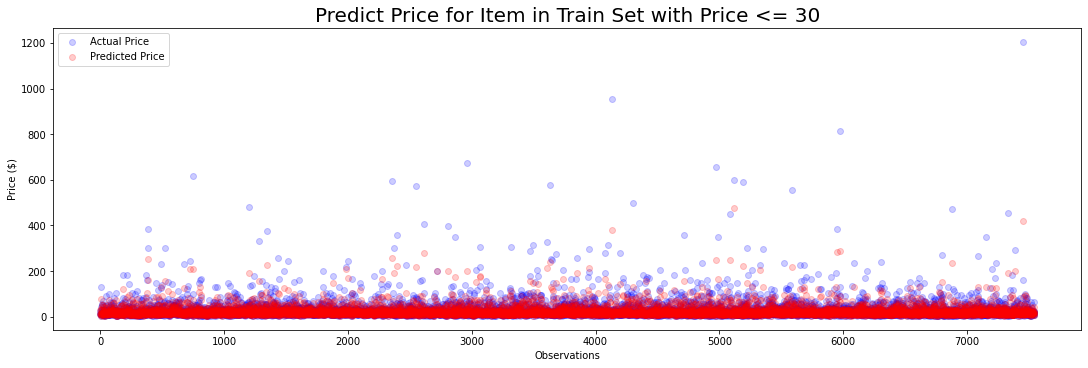

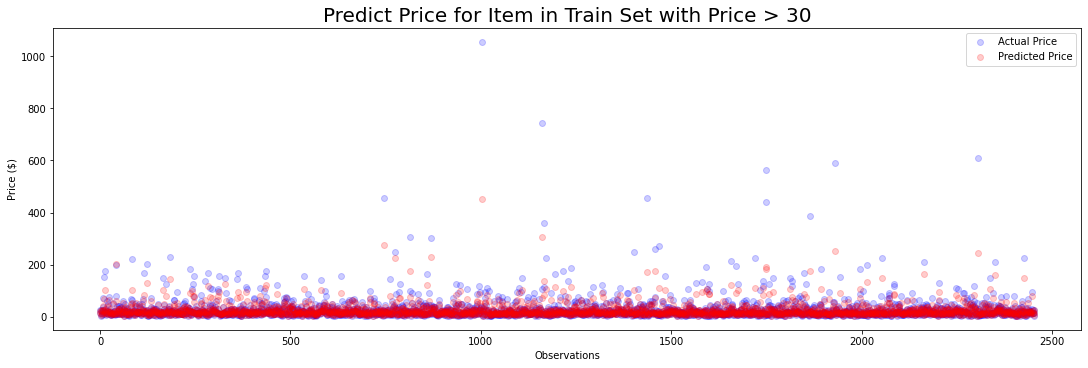

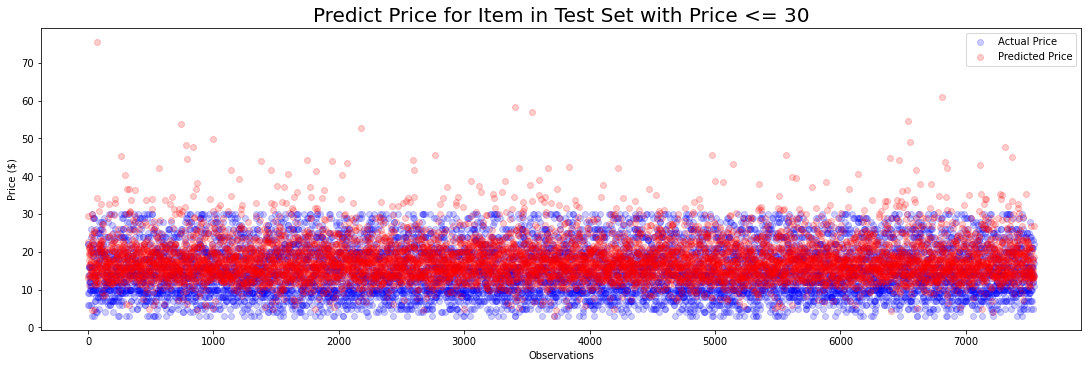

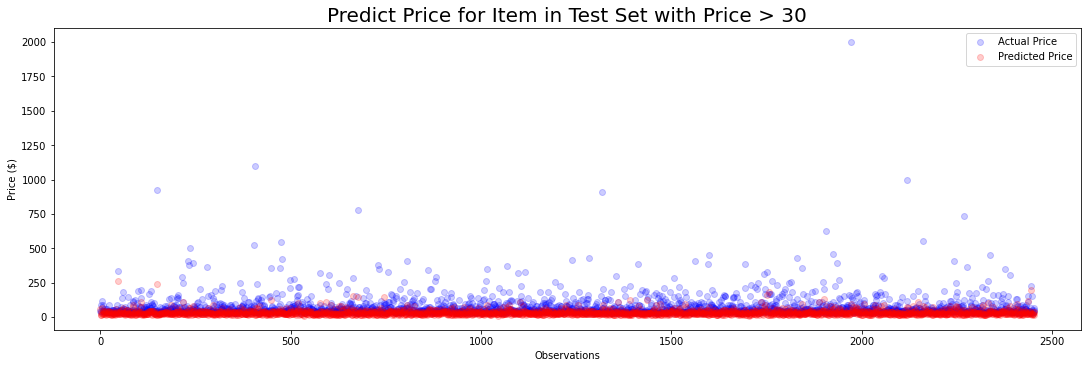

Max Percentage Difference: 152.90 ---- Original Price 3.00, Predict Price 7.59 
Min Percentage Difference: 0.00 ---- Original Price 26.00, Predict Price 26.00 
Max Percentage Difference: 152.90 ---- Original Price 3.00, Predict Price 7.59 
Min Percentage Difference: 0.00 ---- Original Price 26.00, Predict Price 26.00 
Max Percentage Difference: 75.74 ---- Original Price 43.00, Predict Price 75.57 
Min Percentage Difference: 0.00 ---- Original Price 31.00, Predict Price 31.00 
Max Percentage Difference: 1791.41 ---- Original Price 4.00, Predict Price 75.66 
Min Percentage Difference: 0.00 ---- Original Price 19.00, Predict Price 19.00 
Max Percentage Difference: 1791.41 ---- Original Price 4.00, Predict Price 75.66 
Min Percentage Difference: 0.00 ---- Original Price 19.00, Predict Price 19.00 
Max Percentage Difference: 97.72 ---- Original Price 731.00, Predict Price 16.66 
Min Percentage Difference: 0.04 ---- Original Price 31.00, Predict Price 31.01 


In [39]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, rf_train_pred, 
                                                                                   y_test,rf_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train, rf_train_pred, y_test, rf_test_pred,
               price_split=30,print_result = False)

In [40]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,152.899469,0.000495,0.208207,0.926240,16.946352,6.677770
Train with Price <= 30,152.899469,0.000495,0.161474,0.869740,15.276047,1.814882
Train with Price > 30,75.735673,0.002918,0.311405,0.699390,22.130689,21.771332
All Test,1791.413108,0.002531,0.559953,0.466228,48.755898,14.315086
Test with Price <= 30,1791.413108,0.002531,0.435850,0.060663,49.585204,5.403336
Test with Price > 30,97.721306,0.038512,0.832679,-1.134941,46.207174,41.703742


# Light GBM Regressor

### Train with select k best features

In [41]:
lgbm_model = lgbm.LGBMRegressor(n_estimators=200, max_depth=8,learning_rate=0.1)
lgbm_model.fit(x_skb_select_train, y_train)
lgbm_train_pred = lgbm_model.predict(x_skb_select_train)
lgbm_test_pred = lgbm_model.predict(x_skb_select_test)

--------------------------------------------------
For All Price
Train Result ----------
Max Percentage Difference: 919.44 ---- Original Price 3.00, Predict Price 30.58 
Min Percentage Difference: 0.00 ---- Original Price 31.00, Predict Price 31.00 
RMSLE is  0.519663268900014
R^2  is  0.5405124077662213
Mean Absolute Percentage Error is  46.12948635613128
Mean Absolute Error is  12.541219519972385

Test Result ----------
Max Percentage Difference: 2388.86 ---- Original Price 4.00, Predict Price 99.55 
Min Percentage Difference: 0.00 ---- Original Price 46.00, Predict Price 46.00 
RMSLE is  0.5627872449742746
R^2 is  0.4608110277394911
Mean Absolute Percentage Error is  50.758667095678625
Mean Absolute Error is  14.03765322040528
--------------------------------------------------
For price under $30
Train Result ----------
Max Percentage Difference: 919.44 ---- Original Price 3.00, Predict Price 30.58 
Min Percentage Difference: 0.01 ---- Original Price 15.00, Predict Price 15.00 
RMSL

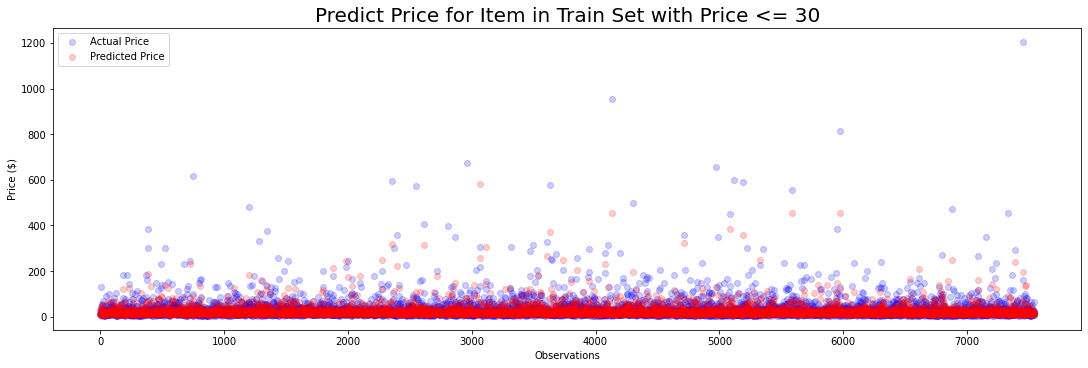

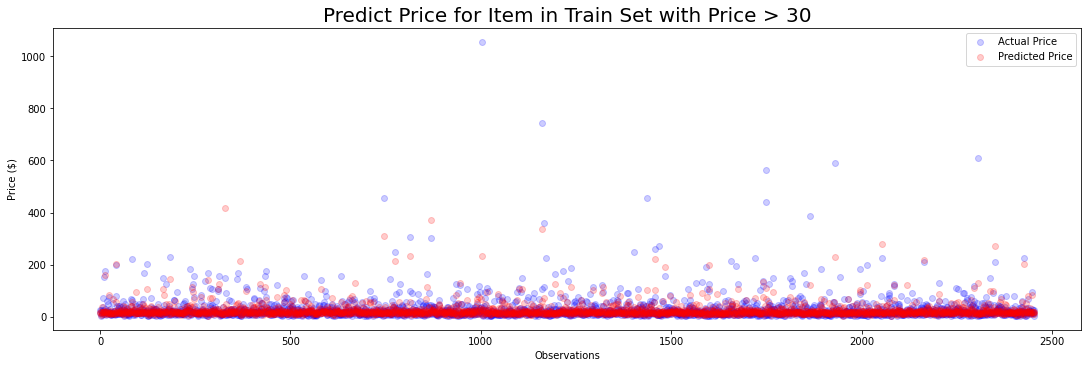

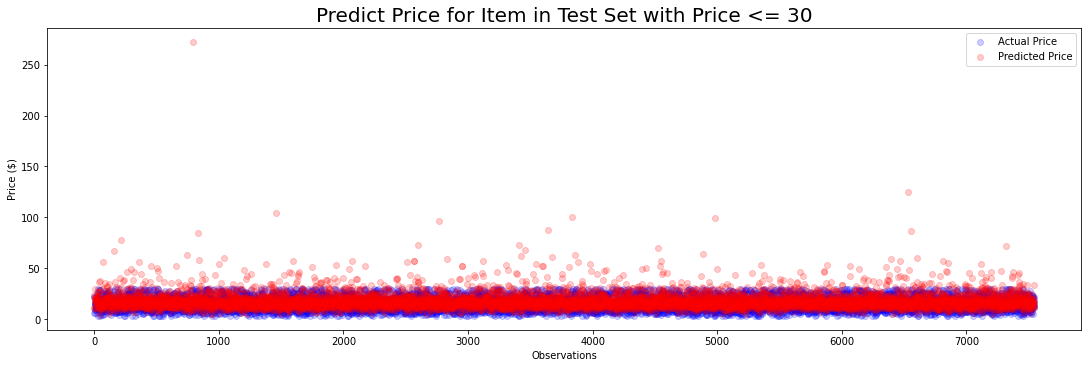

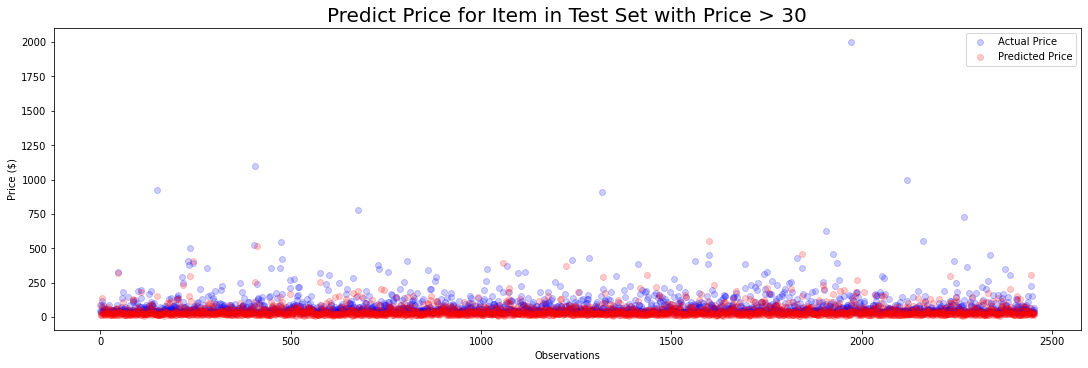

Max Percentage Difference: 919.44 ---- Original Price 3.00, Predict Price 30.58 
Min Percentage Difference: 0.00 ---- Original Price 31.00, Predict Price 31.00 
Max Percentage Difference: 919.44 ---- Original Price 3.00, Predict Price 30.58 
Min Percentage Difference: 0.01 ---- Original Price 15.00, Predict Price 15.00 
Max Percentage Difference: 398.74 ---- Original Price 43.00, Predict Price 214.46 
Min Percentage Difference: 0.00 ---- Original Price 31.00, Predict Price 31.00 
Max Percentage Difference: 2388.86 ---- Original Price 4.00, Predict Price 99.55 
Min Percentage Difference: 0.00 ---- Original Price 46.00, Predict Price 46.00 
Max Percentage Difference: 2388.86 ---- Original Price 4.00, Predict Price 99.55 
Min Percentage Difference: 0.00 ---- Original Price 26.00, Predict Price 26.00 
Max Percentage Difference: 491.75 ---- Original Price 35.00, Predict Price 207.11 
Min Percentage Difference: 0.00 ---- Original Price 46.00, Predict Price 46.00 


In [42]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, lgbm_train_pred,
                                                                                   y_test, lgbm_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train, lgbm_train_pred, y_test, lgbm_test_pred,
               price_split=30,print_result = True)

In [43]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,919.435534,0.001752,0.519663,0.540512,46.129486,12.541220
Train with Price <= 30,919.435534,0.007754,0.429529,0.078307,47.503860,5.608856
Train with Price > 30,398.735089,0.001752,0.731846,-0.660324,41.863669,34.058076
All Test,2388.863872,0.000063,0.562787,0.460811,50.758667,14.037653
Test with Price <= 30,2388.863872,0.002313,0.460126,-0.046885,52.269634,6.113632
Test with Price > 30,491.749284,0.000063,0.799669,-0.969025,46.114981,38.390703


### Train with All features

In [44]:
lgbm_model = lgbm.LGBMRegressor(n_estimators=200, max_depth=8,learning_rate=0.1)
lgbm_model.fit(all_train, y_train)
lgbm_train_pred = lgbm_model.predict(all_train)
lgbm_test_pred = lgbm_model.predict(all_test)

--------------------------------------------------
For All Price
Train Result ----------
Max Percentage Difference: 761.67 ---- Original Price 13.00, Predict Price 112.02 
Min Percentage Difference: 0.00 ---- Original Price 11.00, Predict Price 11.00 
RMSLE is  0.48695999225578396
R^2  is  0.5965252972408133
Mean Absolute Percentage Error is  43.04216591213276
Mean Absolute Error is  12.208946393404162

Test Result ----------
Max Percentage Difference: 1309.96 ---- Original Price 3.00, Predict Price 42.30 
Min Percentage Difference: 0.01 ---- Original Price 14.00, Predict Price 14.00 
RMSLE is  0.5302111426411071
R^2 is  0.5214247774156437
Mean Absolute Percentage Error is  47.19950924129905
Mean Absolute Error is  13.388081743127023
--------------------------------------------------
For price under $30
Train Result ----------
Max Percentage Difference: 761.67 ---- Original Price 13.00, Predict Price 112.02 
Min Percentage Difference: 0.00 ---- Original Price 11.00, Predict Price 11.00

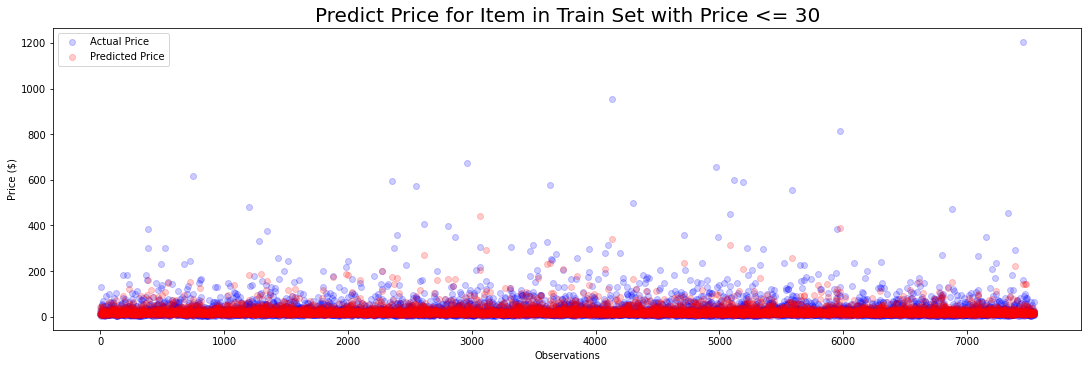

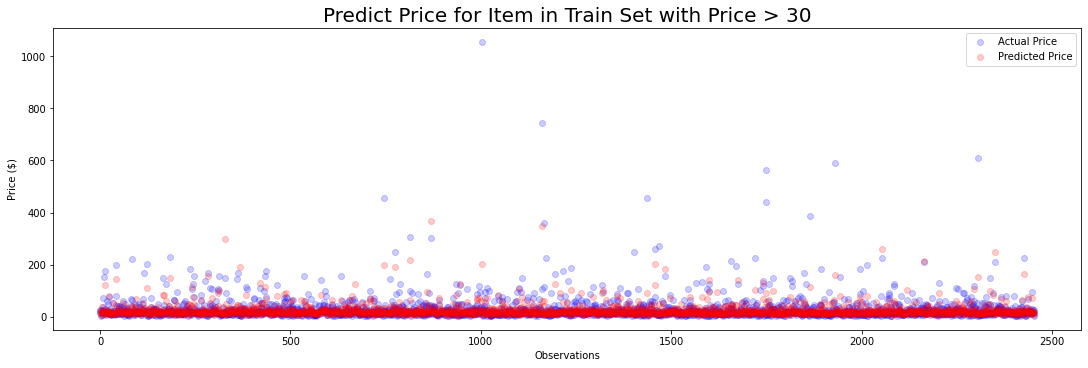

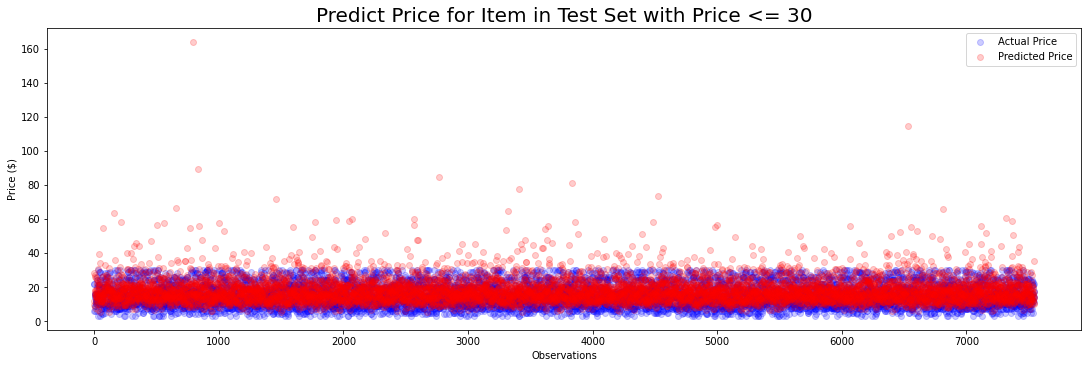

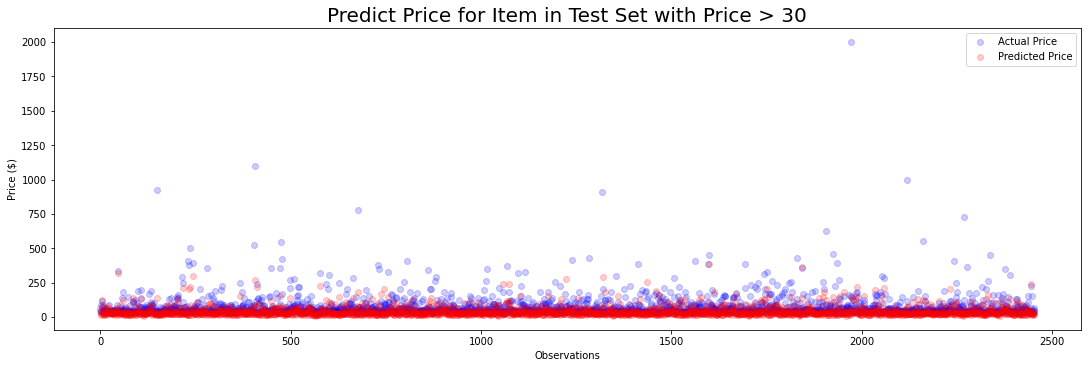

Max Percentage Difference: 761.67 ---- Original Price 13.00, Predict Price 112.02 
Min Percentage Difference: 0.00 ---- Original Price 11.00, Predict Price 11.00 
Max Percentage Difference: 761.67 ---- Original Price 13.00, Predict Price 112.02 
Min Percentage Difference: 0.00 ---- Original Price 11.00, Predict Price 11.00 
Max Percentage Difference: 340.84 ---- Original Price 43.00, Predict Price 189.56 
Min Percentage Difference: 0.00 ---- Original Price 44.00, Predict Price 44.00 
Max Percentage Difference: 1309.96 ---- Original Price 3.00, Predict Price 42.30 
Min Percentage Difference: 0.01 ---- Original Price 14.00, Predict Price 14.00 
Max Percentage Difference: 1309.96 ---- Original Price 3.00, Predict Price 42.30 
Min Percentage Difference: 0.01 ---- Original Price 14.00, Predict Price 14.00 
Max Percentage Difference: 314.96 ---- Original Price 35.00, Predict Price 145.24 
Min Percentage Difference: 0.02 ---- Original Price 32.00, Predict Price 32.01 


In [45]:
ori_train_price, ori_test_price, pred_train_price, pred_test_price = get_ori_price(y_train, lgbm_train_pred,
                                                                                   y_test, lgbm_test_pred)

result_df = reg_evaluation(ori_train_price, ori_test_price, pred_train_price, pred_test_price,  # origin price
               y_train, lgbm_train_pred, y_test, lgbm_test_pred,
               price_split=30,print_result = True)

In [46]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,761.667367,0.000828,0.486960,0.596525,43.042166,12.208946
Train with Price <= 30,761.667367,0.000828,0.404731,0.181659,44.030030,5.176766
Train with Price > 30,340.835533,0.003135,0.681698,-0.440584,39.976008,34.035615
All Test,1309.957669,0.014586,0.530211,0.521425,47.199509,13.388082
Test with Price <= 30,1309.957669,0.014586,0.434557,0.066230,48.372081,5.635130
Test with Price > 30,314.961515,0.021863,0.751493,-0.738924,43.595821,37.215382


# Neural Network

### Train with select k best features

In [52]:
model = neural_network(model_prefix="select_k_best_brand_sample", nodes=[64, 16,16], dropouts = [0.1,0.1,0.1])
model.fit(x_skb_select_train, y_train.values, x_skb_select_test, y_test.values,
          n_epoch=30,epoch=1, bs=128)

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 1s 30us/step - loss: 1.7831 - val_loss: 0.3565
Train on 40000 samples, validate on 10000 samples
Epoch 2/2
40000/40000 [==============================] - 1s 22us/step - loss: 0.6086 - val_loss: 0.3403
Train on 40000 samples, validate on 10000 samples
Epoch 3/3
40000/40000 [==============================] - 1s 23us/step - loss: 0.5509 - val_loss: 0.3671
Train on 40000 samples, validate on 10000 samples
Epoch 4/4
40000/40000 [==============================] - 1s 23us/step - loss: 0.5307 - val_loss: 0.3396
Train on 40000 samples, validate on 10000 samples
Epoch 5/5
40000/40000 [==============================] - 1s 22us/step - loss: 0.4962 - val_loss: 0.3509
Save Model:  select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03_ep5.h5
Train on 40000 samples, validate on 10000 samples
Epoch 6/6
40000/40000 [==============================] - 1s 22us/step - loss: 0.4820 - va

In [48]:
model.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                32064     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

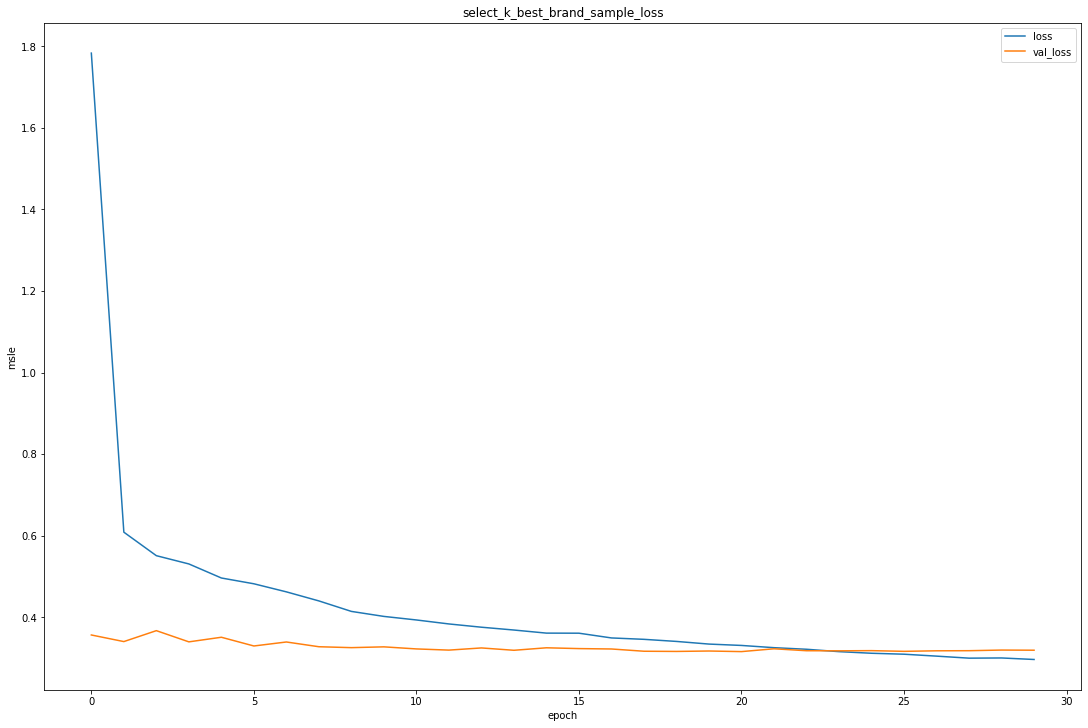

In [55]:
skb_select_loss = np.load("%s/%s_loss.npy"%(model.model_name,model.model_name))[:,:,0]
plot_loss(skb_select_loss[:,0],skb_select_loss[:,1], title="select_k_best_brand_sample_loss")

In [66]:
model = neural_network(model_name = "select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03_ep20.h5")

loading model


In [68]:
model.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                32064     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [69]:
skb_select_train_pred = model.predict(x_skb_select_train)
skb_select_test_pred = model.predict(x_skb_select_test)

Result of using select_k_best_brand_sample_NN_64_dr1e-01_16_dr1e-01_16_dr1e-01_lr1e-03


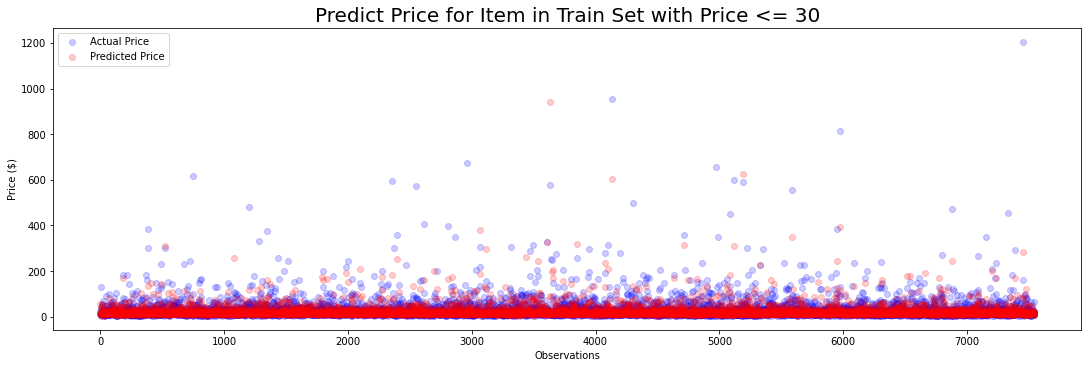

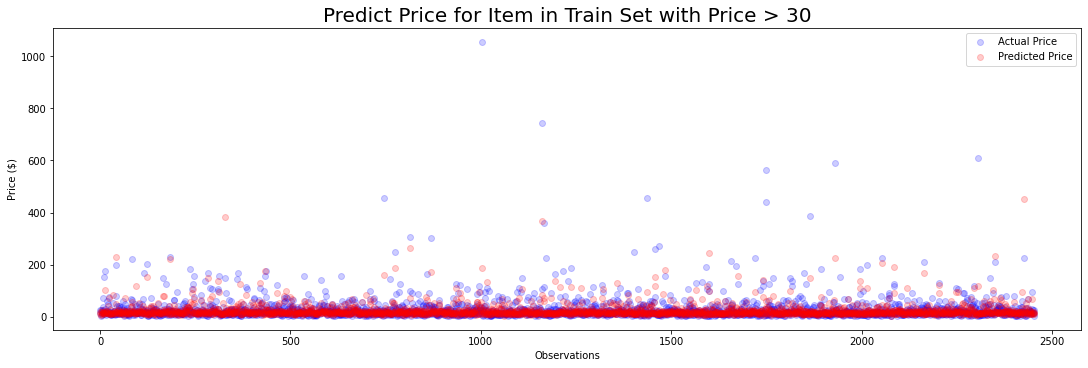

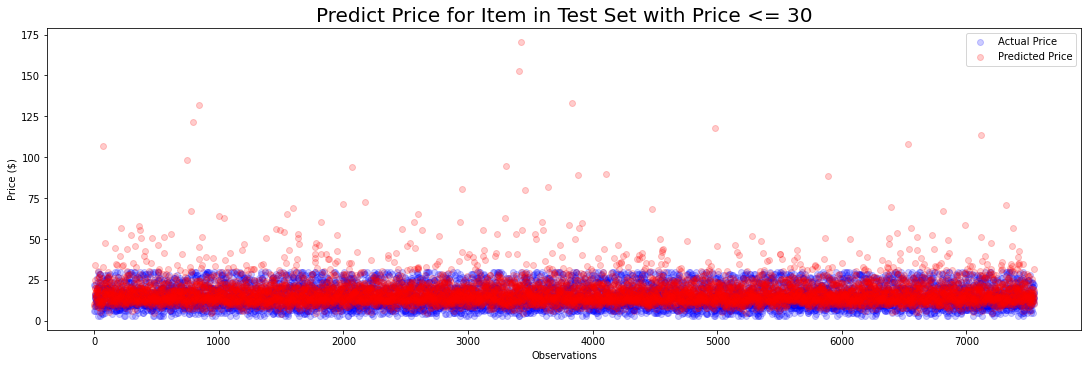

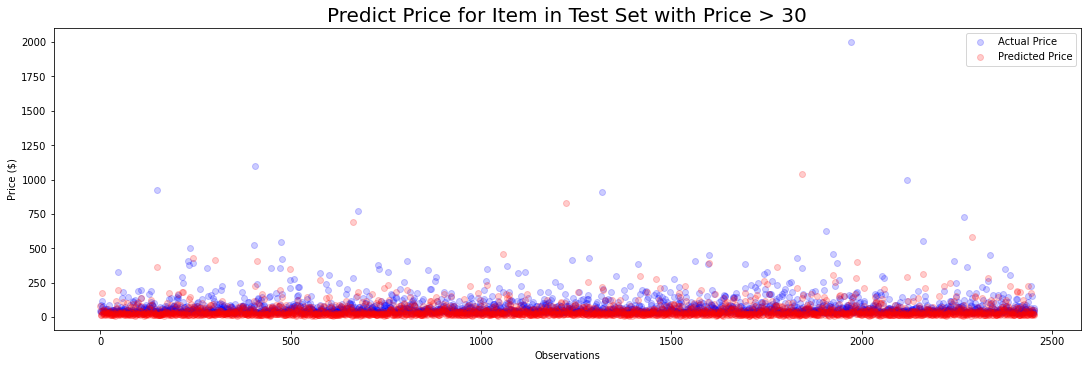

Max Percentage Difference: 1074.17 ---- Original Price 3.00, Predict Price 35.23 
Min Percentage Difference: 0.00 ---- Original Price 14.00, Predict Price 14.00 
Max Percentage Difference: 1074.17 ---- Original Price 3.00, Predict Price 35.23 
Min Percentage Difference: 0.00 ---- Original Price 14.00, Predict Price 14.00 
Max Percentage Difference: 652.32 ---- Original Price 49.00, Predict Price 368.64 
Min Percentage Difference: 0.00 ---- Original Price 35.00, Predict Price 35.00 
Max Percentage Difference: 2845.25 ---- Original Price 4.00, Predict Price 117.81 
Min Percentage Difference: 0.01 ---- Original Price 15.00, Predict Price 15.00 
Max Percentage Difference: 2845.25 ---- Original Price 4.00, Predict Price 117.81 
Min Percentage Difference: 0.01 ---- Original Price 15.00, Predict Price 15.00 
Max Percentage Difference: 622.58 ---- Original Price 115.00, Predict Price 830.96 
Min Percentage Difference: 0.33 ---- Original Price 55.00, Predict Price 54.82 


In [70]:
result_df = model.evaluation(y_train, skb_select_train_pred, y_test, skb_select_test_pred, price_split=30,
                                                print_result = False)

In [71]:
result_df 

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,1074.173355,0.002738,0.530510,0.521130,45.347032,12.679733
Train with Price <= 30,1074.173355,0.002738,0.426870,0.089681,45.851026,5.571093
Train with Price > 30,652.319274,0.003575,0.767732,-0.827144,43.782722,34.743721
All Test,2845.253754,0.010249,0.563199,0.460022,49.406988,14.057860
Test with Price <= 30,2845.253754,0.010249,0.452144,-0.010882,49.937998,5.989281
Test with Price > 30,622.575365,0.326143,0.814700,-1.043742,47.775024,38.855183


### Train with All features

In [75]:
all_model = neural_network(model_prefix="all_data_brand_sample",
                           nodes=[128, 64, 32,16], dropouts = [0.1, 0.1,0.1,0.1])
all_model.fit(all_train, y_train.values, all_test, y_test.values,
              n_epoch=10,epoch=1, bs=128)

Train on 40000 samples, validate on 10000 samples
Epoch 1/1
40000/40000 [==============================] - 13s 327us/step - loss: 0.8793 - val_loss: 0.2666
Train on 40000 samples, validate on 10000 samples
Epoch 2/2
40000/40000 [==============================] - 12s 309us/step - loss: 0.4071 - val_loss: 0.2544
Train on 40000 samples, validate on 10000 samples
Epoch 3/3
40000/40000 [==============================] - 15s 370us/step - loss: 0.3561 - val_loss: 0.2509
Train on 40000 samples, validate on 10000 samples
Epoch 4/4
40000/40000 [==============================] - 13s 331us/step - loss: 0.3126 - val_loss: 0.2575
Train on 40000 samples, validate on 10000 samples
Epoch 5/5
40000/40000 [==============================] - 12s 306us/step - loss: 0.2759 - val_loss: 0.2529
Save Model:  all_data_brand_sample_NN_128_dr1e-01_64_dr1e-01_32_dr1e-01_16_dr1e-01_lr1e-03_ep5.h5
Train on 40000 samples, validate on 10000 samples
Epoch 6/6
40000/40000 [==============================] - 12s 305us/step 

In [76]:
all_model.model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               2546048   
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 16)               

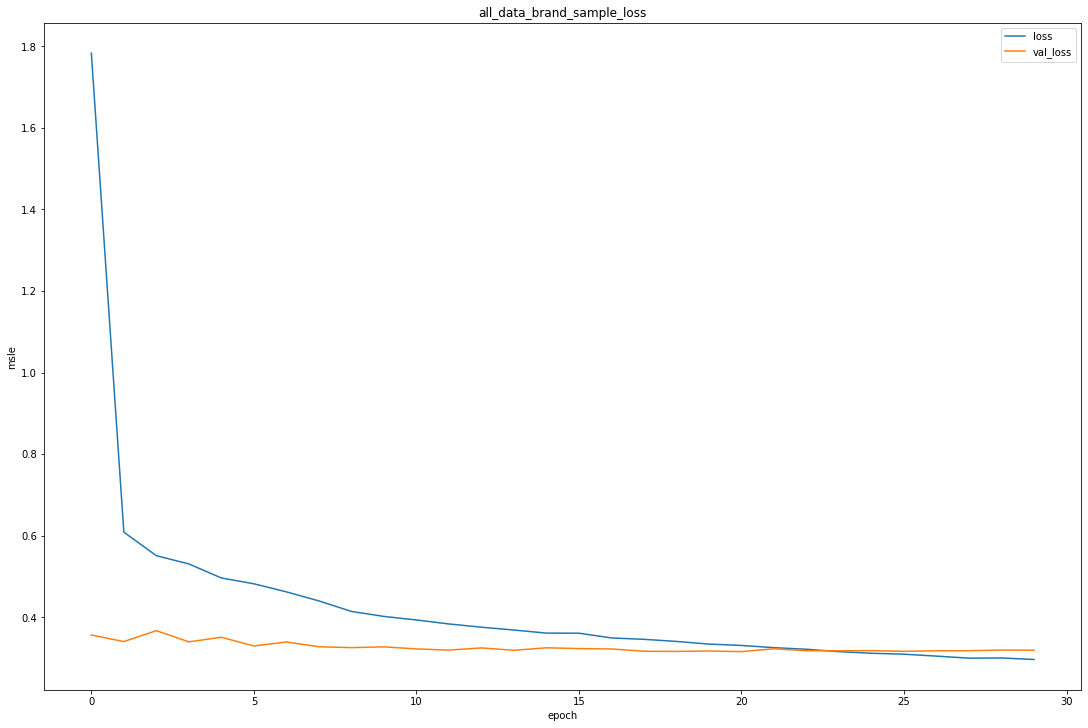

In [77]:
all_loss = np.load("%s/%s_loss.npy"%(all_model.model_name,all_model.model_name))[:,:,0]
plot_loss(skb_select_loss[:,0],skb_select_loss[:,1], title="all_data_brand_sample_loss")

In [78]:
all_train_pred = all_model.predict(all_train)
all_test_pred = all_model.predict(all_test)

Result of using all_data_brand_sample_NN_128_dr1e-01_64_dr1e-01_32_dr1e-01_16_dr1e-01_lr1e-03


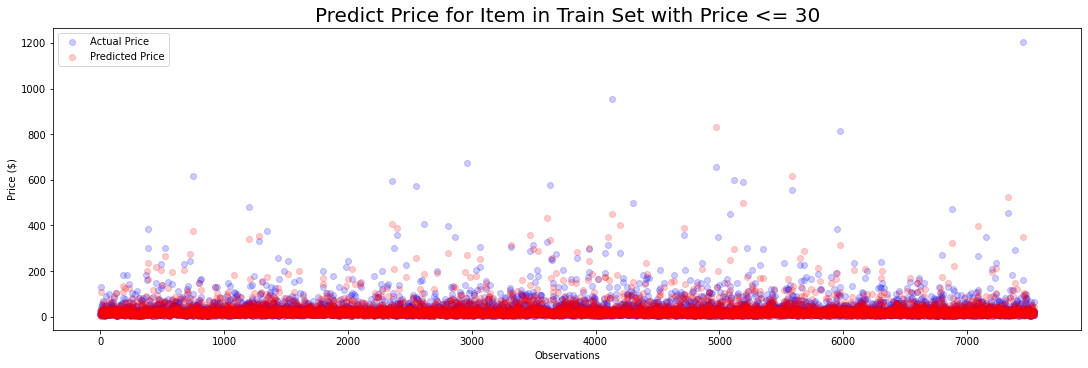

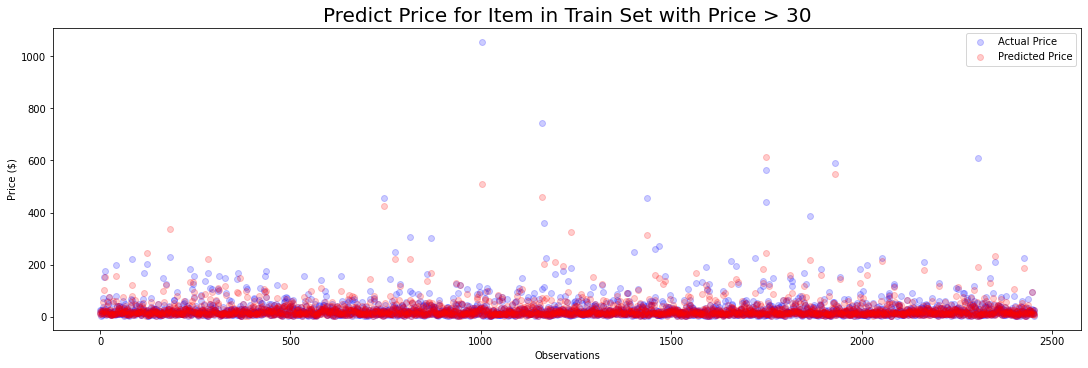

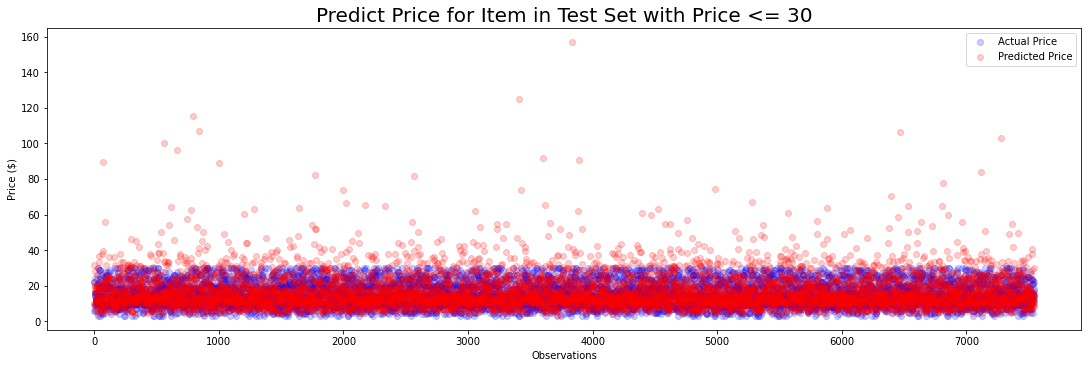

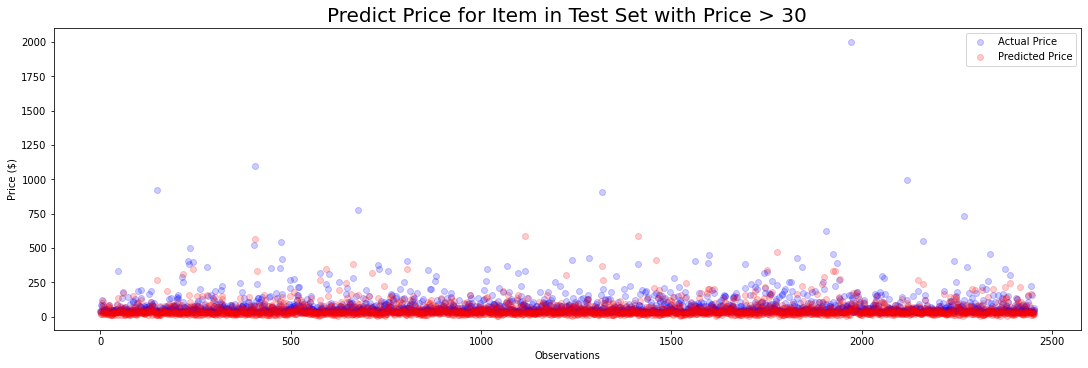

Max Percentage Difference: 493.96 ---- Original Price 3.00, Predict Price 17.82 
Min Percentage Difference: 0.00 ---- Original Price 29.00, Predict Price 29.00 
Max Percentage Difference: 493.96 ---- Original Price 3.00, Predict Price 17.82 
Min Percentage Difference: 0.00 ---- Original Price 29.00, Predict Price 29.00 
Max Percentage Difference: 247.82 ---- Original Price 43.00, Predict Price 149.56 
Min Percentage Difference: 0.01 ---- Original Price 38.00, Predict Price 38.00 
Max Percentage Difference: 2138.93 ---- Original Price 4.00, Predict Price 89.56 
Min Percentage Difference: 0.01 ---- Original Price 16.00, Predict Price 16.00 
Max Percentage Difference: 2138.93 ---- Original Price 4.00, Predict Price 89.56 
Min Percentage Difference: 0.01 ---- Original Price 16.00, Predict Price 16.00 
Max Percentage Difference: 358.64 ---- Original Price 35.00, Predict Price 160.52 
Min Percentage Difference: 0.01 ---- Original Price 35.00, Predict Price 35.00 


In [79]:
result_df = all_model.evaluation(y_train, all_train_pred, y_test, all_test_pred, price_split=30,
                                                print_result = False)

In [80]:
result_df

,Max Percentage Diff,Min Percentage Diff,RMSLE,R^2,MAPE,MAE
All Train,493.961843,0.003104,0.237866,0.903729,19.375826,6.545054
Train with Price <= 30,493.961843,0.003104,0.208681,0.782446,18.652557,2.643695
Train with Price > 30,247.821364,0.007308,0.311499,0.699208,21.620728,18.654198
All Test,2138.925171,0.006378,0.503033,0.569231,42.313213,12.687491
Test with Price <= 30,2138.925171,0.006378,0.425702,0.103899,42.537357,5.676822
Test with Price > 30,358.635864,0.006430,0.688308,-0.458799,41.624346,34.233518
